In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


2025-01-12 23:03:33.123801: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-12 23:03:33.137865: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-12 23:03:33.260488: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-12 23:03:33.375808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-12 23:03:33.466751: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [6]:
import pandas as pd

# Load the data with explicit dtype specification for 'StateHoliday'
train_df = pd.read_csv('/home/enat/Downloads/rossmann-store-sales/train.csv', dtype={'StateHoliday': str})

# Display the first few rows of the dataset
print("Train Data:")
print(train_df.head())

# Isolate the 'Date' and 'Sales' columns
# Use .copy() to avoid SettingWithCopyWarning
time_series_data = train_df[['Date', 'Sales']].copy()
time_series_data['Date'] = pd.to_datetime(time_series_data['Date'])
time_series_data.set_index('Date', inplace=True)

# Resample the data to daily sales
daily_sales = time_series_data['Sales'].resample('D').sum()

# Display the resampled data
print("Daily Sales Data:")
print(daily_sales.head())



Train Data:
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
Daily Sales Data:
Date
2013-01-01      97235
2013-01-02    6949829
2013-01-03    6347820
2013-01-04    6638954
2013-01-05    5951593
Freq: D, Name: Sales, dtype: int64


In [7]:
# Check if time series data is stationary
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

check_stationarity(daily_sales)


ADF Statistic: -4.761614524595614
p-value: 6.436731330559359e-05
Critical Values:
   1%, -3.437470108019385
Critical Values:
   5%, -2.8646832620852853
Critical Values:
   10%, -2.5684436698650503


In [8]:
# Differencing the data if necessary
daily_sales_diff = daily_sales.diff().dropna()
check_stationarity(daily_sales_diff)


ADF Statistic: -14.008528601649752
p-value: 3.7500440046049317e-26
Critical Values:
   1%, -3.437470108019385
Critical Values:
   5%, -2.8646832620852853
Critical Values:
   10%, -2.5684436698650503


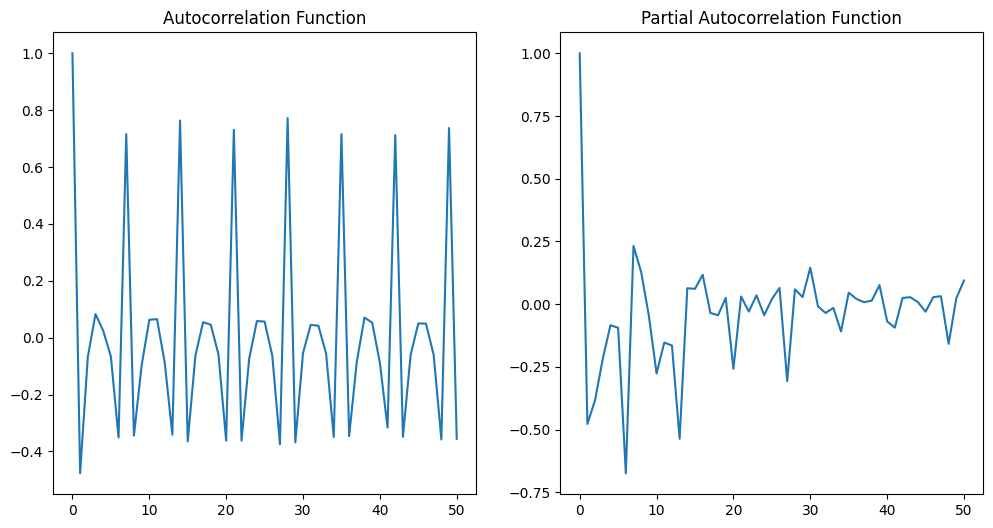

In [9]:
#Check ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(acf(daily_sales_diff, nlags=50))
plt.title('Autocorrelation Function')
plt.subplot(122)
plt.plot(pacf(daily_sales_diff, nlags=50))
plt.title('Partial Autocorrelation Function')
plt.show()


In [10]:
# Create supervised learning data
def create_supervised_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 30  # Example window size
scaled_sales = MinMaxScaler(feature_range=(-1, 1)).fit_transform(daily_sales_diff.values.reshape(-1, 1))
X, y = create_supervised_data(scaled_sales, window_size)

# Split the data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 728, Testing samples: 183


Epoch 1/20


/home/enat/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1267 - val_loss: 0.1247
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1070 - val_loss: 0.1217
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1116 - val_loss: 0.1172
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1004 - val_loss: 0.1105
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0994 - val_loss: 0.1015
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0867 - val_loss: 0.0918
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0774 - val_loss: 0.0817
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0743 - val_loss: 0.0741
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0649 - val_loss: 0.0702
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0611 - val_loss: 0.0668
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0628 - val_loss: 0.0701
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0636 - val_l

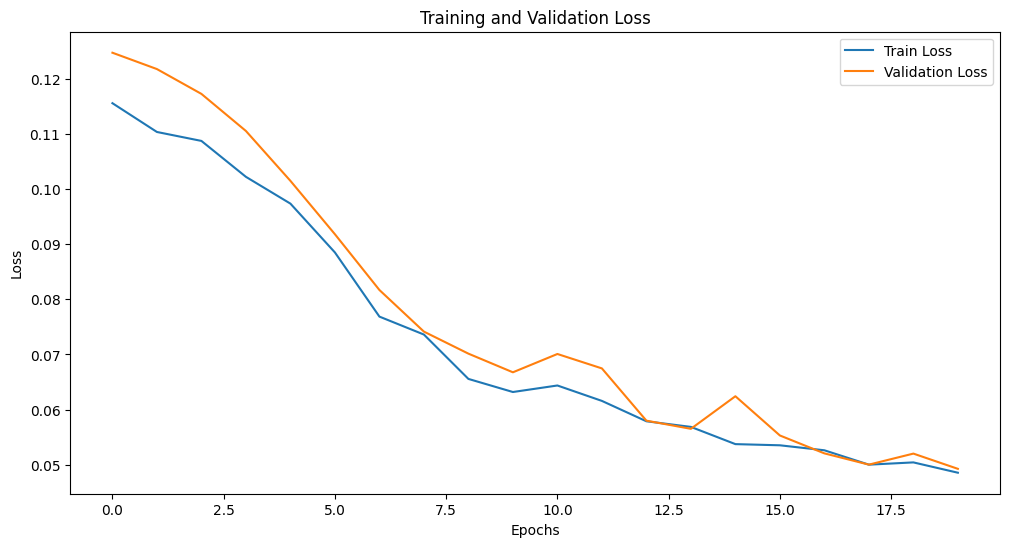

In [11]:
#Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
from sklearn.metrics import mean_squared_error
# Make predictions and evaluate the model
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inverse = MinMaxScaler().fit(daily_sales_diff.values.reshape(-1, 1)).inverse_transform(y_pred)
y_test_inverse = MinMaxScaler().fit(daily_sales_diff.values.reshape(-1, 1)).inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Sales')
plt.plot(y_pred_inverse, label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"Mean Squared Error: {mse}")


SyntaxError: invalid syntax (1578077769.py, line 1)